In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time            # value=time*slope(m)

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)
print("The length of the series is:",len(series))
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]         # 0 to 999
time_valid = time[split_time:]
x_valid = series[split_time:]         # 1000 to 1460

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

The length of the series is: 1461


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset.element_spec)
for i in dataset:
  print(i)
  break

(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
(<tf.Tensor: shape=(32, 20), dtype=float32, numpy=
array([[ 41.0233    ,  37.823654  ,  50.228203  ,  46.493633  ,
         39.692234  ,  39.68192   ,  44.49395   ,  54.533825  ,
         44.906883  ,  38.70553   ,  45.0092    ,  44.891247  ,
         32.787647  ,  46.018097  ,  45.15265   ,  49.806374  ,
         55.588398  ,  51.994976  ,  45.036507  ,  40.86737   ],
       [ 49.91921   ,  43.210567  ,  37.96383   ,  38.81263   ,
         47.153587  ,  48.175312  ,  42.31936   ,  49.998848  ,
         38.46393   ,  46.40746   ,  40.649796  ,  43.413387  ,
         46.87793   ,  42.307915  ,  44.656895  ,  51.5815    ,
         43.636585  ,  50.67116   ,  40.81647   ,  49.086952  ],
       [ 27.211473  ,  30.757544  ,  22.38766   ,  22.621704  ,
         26.097902  ,  28.654142  ,  31.307323  ,  37.161125  ,
         34.104355  ,  29.048223  ,  29.784843  ,  24.899433 

In [9]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))


Layer weights [array([[-0.02357286],
       [-0.04117902],
       [ 0.06898709],
       [-0.06622157],
       [ 0.07634253],
       [ 0.0172345 ],
       [-0.02158229],
       [-0.00812638],
       [-0.00132155],
       [ 0.05165393],
       [-0.08102135],
       [-0.01975542],
       [-0.04187774],
       [ 0.09483258],
       [ 0.09126188],
       [ 0.00478204],
       [-0.01532123],
       [ 0.1909388 ],
       [ 0.28683802],
       [ 0.43064234]], dtype=float32), array([0.01747297], dtype=float32)]


In [12]:
len(series) - window_size

1441

1441


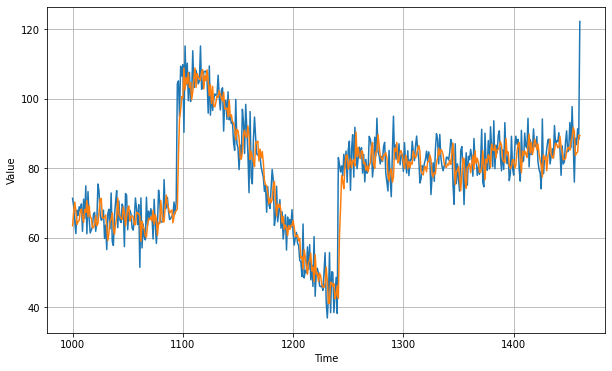

In [15]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))    # [1440:1460]--[1441:1461] 1461 index do not exist
print(len(forecast))
forecast = forecast[split_time-window_size:]             #forecast[980:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
len(forecast)

461

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9829044